In [7]:
pip install pretty_midi


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.8 kB/s eta 0:00:0000:01m00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 77.9 kB/s eta 0:00:00a 0:00:01
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592290 sha256=2373910d37de5a5416ac3a1a60649b3ccece00dafac5f9a6dda1ee6654961828
  Stored in directory: /nfsshare/santhosh/.cache/pip/wheels/a0/2e/c1/5d01e5098d7ecf1e17e2c190e8513a00bdbdece908199f1cf4
Successfully built pretty_midi
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install librosa


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 5.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.

In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade numpy pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 6.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibm-watson-machine-learning 1.0.229 requires pandas<1.4.0,>=0.24.2, but you have pandas 2.2.3 which is incompatible.
auto-sklearn 0.14.7 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.4.0 which is incompatible.
arviz 0.11.2 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.13.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pretty_midi
import librosa
from tqdm import tqdm

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
ROOT_DIR = "/nfsshare/santhosh/maestro-v2.0.0/preprocessed"
OUTPUT_DIR = os.path.join(ROOT_DIR, "preprocessed_splits")
MIDI_DIR = ROOT_DIR  # Assuming MIDI files are in ROOT_DIR

# Ensure output directories
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'mel'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'piano_roll'), exist_ok=True)

def midi_to_targets(midi_file, frames=TARGET_FRAMES, hop=HOP_LENGTH, sr=SR):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        piano_roll = pm.get_piano_roll(fs=sr/hop).T[:frames]  # (frames, 128)
        piano_roll = piano_roll[:, 21:109]  # MIDI 21–108 (88 keys)
        frame = (piano_roll > 0).astype(np.float32)
        onset = np.zeros_like(frame)
        offset = np.zeros_like(frame)
        for note in pm.instruments[0].notes:
            start_frame = int(note.start * sr / hop)
            end_frame = int(note.end * sr / hop)
            pitch = note.pitch - 21
            if start_frame < frames and 0 <= pitch < NOTES:
                onset[start_frame, pitch] = 1
            if end_frame < frames and 0 <= pitch < NOTES:
                offset[end_frame, pitch] = 1
        return {'onset': onset, 'offset': offset, 'frame': frame}
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

def audio_to_mel(audio_file, frames=TARGET_FRAMES):
    try:
        y, sr = librosa.load(audio_file, sr=SR)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        mel = mel[:, :frames]
        if mel.shape[1] < frames:
            mel = np.pad(mel, ((0, 0), (0, frames - mel.shape[1])), mode='constant')
        return mel
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

def preprocess_split(split, midi_files, audio_files):
    mel_dir = os.path.join(OUTPUT_DIR, split, 'mel')
    roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
    for midi_file, audio_file in tqdm(zip(midi_files, audio_files), total=len(midi_files), desc=f"Processing {split}"):
        base = os.path.basename(midi_file).replace('.midi', '')
        mel_out = os.path.join(mel_dir, f"{base}.npy")
        onset_out = os.path.join(roll_dir, f"{base}_onset.npy")
        offset_out = os.path.join(roll_dir, f"{base}_offset.npy")
        frame_out = os.path.join(roll_dir, f"{base}_frame.npy")
        
        # Skip if all outputs exist
        if all(os.path.exists(f) for f in [mel_out, onset_out, offset_out, frame_out]):
            continue
        
        # Process MIDI
        targets = midi_to_targets(midi_file)
        if targets is None:
            continue
        
        # Process audio
        mel = audio_to_mel(audio_file)
        if mel is None:
            continue
        
        # Save
        np.save(mel_out, mel)
        np.save(onset_out, targets['onset'])
        np.save(offset_out, targets['offset'])
        np.save(frame_out, targets['frame'])

# Load MAESTRO metadata (adjust paths if using a CSV or JSON split)
# Example assumes files are split by directory or naming convention
def get_files(split):
    midi_files = []
    audio_files = []
    split_dir = os.path.join(ROOT_DIR, split)
    for f in os.listdir(split_dir):
        if f.endswith('.midi'):
            midi_files.append(os.path.join(split_dir, f))
            audio_file = f.replace('.midi', '.wav')
            if os.path.exists(os.path.join(split_dir, audio_file)):
                audio_files.append(os.path.join(split_dir, audio_file))
            else:
                audio_files.append(None)
    return midi_files, audio_files

# Process each split
for split in ['train', 'validation', 'test']:
    midi_files, audio_files = get_files(split)
    preprocess_split(split, midi_files, audio_files)

print("Preprocessing complete.")

Processing train: 0it [00:00, ?it/s]
Processing validation: 0it [00:00, ?it/s]
Processing test: 0it [00:00, ?it/s]

Preprocessing complete.


In [4]:
import os
import numpy as np
import pretty_midi
import librosa
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models , Model 
from keras import callbacks
from keras.optimizers import Adam
#Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88

# Paths
ROOT_DIR = "/nfsshare/santhosh/maestro-v2.0.0"
OUTPUT_DIR = os.path.join(ROOT_DIR, "preprocessed")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out):
        super(GCNSimple, self).__init__()
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.2),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features),
        layers.Dropout(0.48)
    ])
    return model

# OnsetsAndFrames model (velocity removed)
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48):
        super(OnsetsAndFrames, self).__init__()
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {
            'onset': onset_pred,
            'offset': offset_pred,
            'frame': frame_pred
        }

# Data generator (velocity removed)
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split,batch_size=8):
        self.split = split
        self.batch_size = batch_size
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        X = np.transpose(X, (0, 2, 1))
        y = np.transpose(y, (0, 2, 1))
        
        return X, {'onset': y, 'offset': y, 'frame': y}
    
    def on_epoch_end(self):
        indices = np.arange(len(self.audio_files))
        np.random.shuffle(indices)
        self.audio_files = [self.audio_files[i] for i in indices]
        self.roll_files = [self.roll_files[i] for i in indices]

# Training function
def train_model():
    train_gen = PianoDataGenerator('train', batch_size=8)
    val_gen = PianoDataGenerator('validation', batch_size=8)
    
    model = OnsetsAndFrames(input_features=N_MELS, output_features=NOTES)
    
    initial_learning_rate = 0.00035
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.97, staircase=True
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss={
            'onset': 'binary_crossentropy',
            'offset': 'binary_crossentropy',
            'frame': 'binary_crossentropy'
        },
        loss_weights={'onset': 1.0, 'offset': 1.0, 'frame': 1.0}
    )
    
    z1 = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=12, factor=0.75, min_lr=1e-6, verbose=1),
    z2 = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", verbose=1),
    z3 = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

    
    history = model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[z2 , z1 , z3])
    
    return model, history

# Evaluation
def evaluate_model(model, val_gen):
    predictions = model.predict(val_gen)
    print("Evaluation complete. Add detailed metrics as needed.")

if __name__ == '__main__':
    model, history = train_model()
    evaluate_model(model, PianoDataGenerator('validation', batch_size=8))

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.3918 - loss: 0.8196 - offset_loss: 0.2128 - onset_loss: 0.2150
Epoch 1: val_loss improved from inf to 0.44653, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 771s 6s/step - frame_loss: 0.3907 - loss: 0.8177 - offset_loss: 0.2124 - onset_loss: 0.2147 - val_frame_loss: 0.1491 - val_loss: 0.4465 - val_offset_loss: 0.1484 - val_onset_loss: 0.1490 - learning_rate: 3.5000e-04
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.1606 - loss: 0.4701 - offset_loss: 0.1551 - onset_loss: 0.1544
Epoch 2: val_loss improved from 0.44653 to 0.38229, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 717s 6s/step - frame_loss: 0.1606 - loss: 0.4700 - offset_loss: 0.1550 - onset_loss: 0.1544 - val_frame_loss: 0.1463 - val_loss: 0.3823 - val_offset_loss: 0.1186 - val_onset_loss: 0.1174 - learning_rate: 3.5000e-04
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.1525 - loss: 0.3782 - offset_loss: 0.1123 - onset_loss: 0.1134
Epoch 3: val_loss did not improve from 0.38229
120/120 ━━━━━━━━━━━━━━━━━━━━ 693s 6s/step - frame_loss: 0.1525 - loss: 0.3781 - offset_loss: 0.1123 - onset_loss: 0.1133 - val_frame_loss: 0.1498 - val_loss: 0.4382 - val_offset_loss: 0.1522 - val_onset_loss: 0.1362 - learning_rate: 3.5000e-04
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.1460 - loss: 0.3109 - offset_loss: 0.0827 - onset_loss: 0.0822
Epoch 4: val_loss improved from 0.38229 to 0.30411, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 724s 6s/step - frame_loss: 0.1459 - loss: 0.3109 - offset_loss: 0.0827 - onset_loss: 0.0822 - val_frame_loss: 0.1489 - val_loss: 0.3041 - val_offset_loss: 0.0757 - val_onset_loss: 0.0795 - learning_rate: 3.5000e-04
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.1367 - loss: 0.2733 - offset_loss: 0.0689 - onset_loss: 0.0677
Epoch 5: val_loss improved from 0.30411 to 0.26538, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 699s 6s/step - frame_loss: 0.1367 - loss: 0.2732 - offset_loss: 0.0689 - onset_loss: 0.0677 - val_frame_loss: 0.1240 - val_loss: 0.2654 - val_offset_loss: 0.0698 - val_onset_loss: 0.0716 - learning_rate: 3.5000e-04
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.1244 - loss: 0.2505 - offset_loss: 0.0629 - onset_loss: 0.0632
Epoch 6: val_loss improved from 0.26538 to 0.23948, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 726s 6s/step - frame_loss: 0.1243 - loss: 0.2504 - offset_loss: 0.0629 - onset_loss: 0.0632 - val_frame_loss: 0.1064 - val_loss: 0.2395 - val_offset_loss: 0.0697 - val_onset_loss: 0.0633 - learning_rate: 3.5000e-04
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.1017 - loss: 0.2062 - offset_loss: 0.0524 - onset_loss: 0.0521
Epoch 7: val_loss improved from 0.23948 to 0.23106, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 712s 6s/step - frame_loss: 0.1017 - loss: 0.2062 - offset_loss: 0.0524 - onset_loss: 0.0521 - val_frame_loss: 0.0995 - val_loss: 0.2311 - val_offset_loss: 0.0658 - val_onset_loss: 0.0658 - learning_rate: 3.5000e-04
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0880 - loss: 0.1848 - offset_loss: 0.0487 - onset_loss: 0.0481
Epoch 8: val_loss improved from 0.23106 to 0.21644, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 784s 6s/step - frame_loss: 0.0880 - loss: 0.1848 - offset_loss: 0.0487 - onset_loss: 0.0481 - val_frame_loss: 0.0920 - val_loss: 0.2164 - val_offset_loss: 0.0626 - val_onset_loss: 0.0618 - learning_rate: 3.5000e-04
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0798 - loss: 0.1705 - offset_loss: 0.0455 - onset_loss: 0.0453
Epoch 9: val_loss improved from 0.21644 to 0.20419, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 719s 6s/step - frame_loss: 0.0798 - loss: 0.1705 - offset_loss: 0.0454 - onset_loss: 0.0453 - val_frame_loss: 0.0836 - val_loss: 0.2042 - val_offset_loss: 0.0612 - val_onset_loss: 0.0595 - learning_rate: 3.5000e-04
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0697 - loss: 0.1531 - offset_loss: 0.0420 - onset_loss: 0.0414
Epoch 10: val_loss improved from 0.20419 to 0.18958, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 744s 6s/step - frame_loss: 0.0697 - loss: 0.1531 - offset_loss: 0.0420 - onset_loss: 0.0414 - val_frame_loss: 0.0790 - val_loss: 0.1896 - val_offset_loss: 0.0554 - val_onset_loss: 0.0552 - learning_rate: 3.5000e-04
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0619 - loss: 0.1402 - offset_loss: 0.0393 - onset_loss: 0.0390
Epoch 11: val_loss did not improve from 0.18958
120/120 ━━━━━━━━━━━━━━━━━━━━ 715s 6s/step - frame_loss: 0.0619 - loss: 0.1402 - offset_loss: 0.0393 - onset_loss: 0.0390 - val_frame_loss: 0.0830 - val_loss: 0.2006 - val_offset_loss: 0.0593 - val_onset_loss: 0.0583 - learning_rate: 3.5000e-04
Epoch 12/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0595 - loss: 0.1374 - offset_loss: 0.0393 - onset_loss: 0.0386
Epoch 12: val_loss improved from 0.18958 to 0.18546, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 721s 6s/step - frame_loss: 0.0595 - loss: 0.1373 - offset_loss: 0.0393 - onset_loss: 0.0386 - val_frame_loss: 0.0757 - val_loss: 0.1855 - val_offset_loss: 0.0557 - val_onset_loss: 0.0541 - learning_rate: 3.5000e-04
Epoch 13/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0520 - loss: 0.1220 - offset_loss: 0.0352 - onset_loss: 0.0349
Epoch 13: val_loss did not improve from 0.18546
120/120 ━━━━━━━━━━━━━━━━━━━━ 739s 6s/step - frame_loss: 0.0520 - loss: 0.1220 - offset_loss: 0.0352 - onset_loss: 0.0349 - val_frame_loss: 0.0802 - val_loss: 0.1910 - val_offset_loss: 0.0570 - val_onset_loss: 0.0538 - learning_rate: 3.5000e-04
Epoch 14/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0495 - loss: 0.1194 - offset_loss: 0.0350 - onset_loss: 0.0349
Epoch 14: val_loss improved from 0.18546 to 0.18050, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 722s 6s/step - frame_loss: 0.0494 - loss: 0.1193 - offset_loss: 0.0350 - onset_loss: 0.0349 - val_frame_loss: 0.0728 - val_loss: 0.1805 - val_offset_loss: 0.0559 - val_onset_loss: 0.0518 - learning_rate: 3.5000e-04
Epoch 15/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0426 - loss: 0.1056 - offset_loss: 0.0317 - onset_loss: 0.0314
Epoch 15: val_loss improved from 0.18050 to 0.17253, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 735s 6s/step - frame_loss: 0.0426 - loss: 0.1056 - offset_loss: 0.0317 - onset_loss: 0.0314 - val_frame_loss: 0.0680 - val_loss: 0.1725 - val_offset_loss: 0.0534 - val_onset_loss: 0.0511 - learning_rate: 3.5000e-04
Epoch 16/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0401 - loss: 0.1011 - offset_loss: 0.0306 - onset_loss: 0.0304
Epoch 16: val_loss did not improve from 0.17253
120/120 ━━━━━━━━━━━━━━━━━━━━ 714s 6s/step - frame_loss: 0.0401 - loss: 0.1011 - offset_loss: 0.0306 - onset_loss: 0.0304 - val_frame_loss: 0.0721 - val_loss: 0.1780 - val_offset_loss: 0.0546 - val_onset_loss: 0.0513 - learning_rate: 3.5000e-04
Epoch 17/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0364 - loss: 0.0936 - offset_loss: 0.0288 - onset_loss: 0.0284
Epoch 17: val_loss did not improve from 0.17253
120/120 ━━━━━━━━━━━━━━━━━━━━ 712s 6s/step - frame_loss: 0.0364 - loss: 0.0936 - offset_loss: 0.0288 - onset_loss: 0.0284 - val_frame_loss: 0.0699 - val_

120/120 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - frame_loss: 0.0256 - loss: 0.0721 - offset_loss: 0.0232 - onset_loss: 0.0232 - val_frame_loss: 0.0690 - val_loss: 0.1714 - val_offset_loss: 0.0504 - val_onset_loss: 0.0520 - learning_rate: 3.5000e-04
Epoch 25/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0255 - loss: 0.0722 - offset_loss: 0.0235 - onset_loss: 0.0231
Epoch 25: val_loss improved from 0.17139 to 0.16689, saving model to best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 808s 6s/step - frame_loss: 0.0255 - loss: 0.0721 - offset_loss: 0.0235 - onset_loss: 0.0231 - val_frame_loss: 0.0662 - val_loss: 0.1669 - val_offset_loss: 0.0509 - val_onset_loss: 0.0498 - learning_rate: 3.5000e-04
Epoch 26/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0231 - loss: 0.0661 - offset_loss: 0.0219 - onset_loss: 0.0212
Epoch 26: val_loss did not improve from 0.16689
120/120 ━━━━━━━━━━━━━━━━━━━━ 755s 6s/step - frame_loss: 0.0231 - loss: 0.0661 - offset_loss: 0.0219 - onset_loss: 0.0212 - val_frame_loss: 0.0667 - val_loss: 0.1716 - val_offset_loss: 0.0533 - val_onset_loss: 0.0516 - learning_rate: 3.5000e-04
Epoch 27/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0220 - loss: 0.0636 - offset_loss: 0.0206 - onset_loss: 0.0210
Epoch 27: val_loss did not improve from 0.16689
120/120 ━━━━━━━━━━━━━━━━━━━━ 826s 6s/step - frame_loss: 0.0220 - loss: 0.0636 - offset_loss: 0.0206 - onset_loss: 0.0210 - val_frame_loss: 0.0778 - val_

120/120 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - frame_loss: 0.0172 - loss: 0.0520 - offset_loss: 0.0175 - onset_loss: 0.0173 - val_frame_loss: 0.0662 - val_loss: 0.1662 - val_offset_loss: 0.0486 - val_onset_loss: 0.0514 - learning_rate: 3.5000e-04
Epoch 32/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0188 - loss: 0.0559 - offset_loss: 0.0186 - onset_loss: 0.0185
Epoch 32: val_loss did not improve from 0.16625
120/120 ━━━━━━━━━━━━━━━━━━━━ 796s 6s/step - frame_loss: 0.0188 - loss: 0.0559 - offset_loss: 0.0186 - onset_loss: 0.0185 - val_frame_loss: 0.0769 - val_loss: 0.1785 - val_offset_loss: 0.0508 - val_onset_loss: 0.0509 - learning_rate: 3.5000e-04
Epoch 33/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - frame_loss: 0.0165 - loss: 0.0503 - offset_loss: 0.0170 - onset_loss: 0.0169
Epoch 33: val_loss did not improve from 0.16625
120/120 ━━━━━━━━━━━━━━━━━━━━ 773s 6s/step - frame_loss: 0.0165 - loss: 0.0503 - offset_loss: 0.0170 - onset_loss: 0.0169 - val_frame_loss: 0.0847 - val_

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [3]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import mir_eval
import pretty_midi
from sklearn.metrics import precision_score, recall_score, f1_score

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
ROOT_DIR = "/nfsshare/santhosh/maestro-v2.0.0"
OUTPUT_DIR = os.path.join(ROOT_DIR, "preprocessed")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out, **kwargs):
        super(GCNSimple, self).__init__(**kwargs)
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)
    
    def get_config(self):
        config = super(GCNSimple, self).get_config()
        config.update({'dim_in': self.fc1.units, 'dim_out': self.fc3.units})
        return config

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.2),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features),
        layers.Dropout(0.5)
    ])
    return model

# OnsetsAndFrames model
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48, **kwargs):
        super(OnsetsAndFrames, self).__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.model_complexity = model_complexity
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {'onset': onset_pred, 'offset': offset_pred, 'frame': frame_pred}
    
    def get_config(self):
        config = super(OnsetsAndFrames, self).get_config()
        config.update({
            'input_features': self.input_features,
            'output_features': self.output_features,
            'model_complexity': self.model_complexity
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        input_features = config.get('input_features', N_MELS)
        output_features = config.get('output_features', NOTES)
        model_complexity = config.get('model_complexity', 48)
        return cls(input_features=input_features, 
                   output_features=output_features, 
                   model_complexity=model_complexity)

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=1, shuffle=False):
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        # Ensure 3D shape
        if X.ndim == 2:
            X = np.expand_dims(X, axis=0)
        if y.ndim == 2:
            y = np.expand_dims(y, axis=0)
        
        # Transpose to (batch, frames, features)
        if X.shape[1] == N_MELS and X.shape[2] == TARGET_FRAMES:
            X = np.transpose(X, (0, 2, 1))
        elif X.shape[1] != TARGET_FRAMES or X.shape[2] != N_MELS:
            raise ValueError(f"Unexpected X shape: {X.shape}")
        
        if y.shape[1] == NOTES and y.shape[2] == TARGET_FRAMES:
            y = np.transpose(y, (0, 2, 1))
        elif y.shape[1] != TARGET_FRAMES or y.shape[2] != NOTES:
            raise ValueError(f"Unexpected y shape: {y.shape}")
        
        return X, y  # Return y as array, not dict
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.audio_files))
            np.random.shuffle(indices)
            self.audio_files = [self.audio_files[i] for i in indices]
            self.roll_files = [self.roll_files[i] for i in indices]

# Custom function to convert piano roll to note intervals and pitches
def roll_to_notes(pianoroll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    for pitch in range(pianoroll.shape[1]):
        active = False
        start = 0
        for t in range(pianoroll.shape[0]):
            if pianoroll[t, pitch] >= 0.5 and not active:  # Adjusted for sigmoid output
                start = t
                active = True
            elif pianoroll[t, pitch] < 0.5 and active:
                end = t
                active = False
                note = pretty_midi.Note(
                    velocity=100,
                    pitch=pitch + 21,  # MIDI pitch offset
                    start=start / fs,
                    end=end / fs
                )
                instrument.notes.append(note)
        if active:
            note = pretty_midi.Note(
                velocity=100,
                pitch=pitch + 21,
                start=start / fs,
                end=pianoroll.shape[0] / fs
            )
            instrument.notes.append(note)

    pm.instruments.append(instrument)
    intervals = np.array([[note.start, note.end] for note in instrument.notes])
    pitches = np.array([note.pitch for note in instrument.notes])
    return intervals, pitches

# Load the best model
model = tf.keras.models.load_model(
    "best_model.h5",
    custom_objects={'OnsetsAndFrames': OnsetsAndFrames, 'GCNSimple': GCNSimple}
)

# Set up test data generator
test_gen = PianoDataGenerator('validation', batch_size=1, shuffle=False)  # Using 'validation' split

Y_true_all, Y_pred_all = [], []

# Predict and collect safely
for i in range(len(test_gen)):
    try:
        batch_x, batch_y = test_gen[i]
    except ValueError as e:
        print(f"⏭️ Skipping batch {i}: {e}")
        continue

    print(f"📦 Batch {i}: {test_gen.audio_files[i * test_gen.batch_size:(i + 1) * test_gen.batch_size]}")
    
    preds = model.predict(batch_x, verbose=0)  # Dictionary output
    pred_frame = preds['frame']  # Use frame output
    pred_frame = np.round(pred_frame).astype(int)

    Y_pred_all.append(pred_frame[0])  # Take first item of batch (batch_size=1)
    Y_true_all.append(batch_y[0])    # True piano roll

# ========== Frame-level Evaluation ==========
Y_true_flat = np.array(Y_true_all).reshape(-1)
Y_pred_flat = np.array(Y_pred_all).reshape(-1)

frame_precision = precision_score(Y_true_flat, Y_pred_flat, zero_division=0)
frame_recall = recall_score(Y_true_flat, Y_pred_flat, zero_division=0)
frame_f1 = f1_score(Y_true_flat, Y_pred_flat, zero_division=0)

print("\n🎯 Frame-level Metrics:")
print(f"Precision: {frame_precision:.4f}")
print(f"Recall   : {frame_recall:.4f}")
print(f"F1-score : {frame_f1:.4f}")

# ========== Note-level Evaluation ==========
note_precision, note_recall, note_f1 = [], [], []
note_off_precision, note_off_recall, note_off_f1 = [], [], []

for i in range(len(Y_true_all)):
    true_roll = Y_true_all[i].T  # (notes, frames)
    pred_roll = Y_pred_all[i].T  # (notes, frames)

    ref_intervals, ref_pitches = roll_to_notes(true_roll, fs=100)
    est_intervals, est_pitches = roll_to_notes(pred_roll, fs=100)

    # Note-level (onset only)
    scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches, est_intervals, est_pitches
    )
    note_precision.append(scores[0])
    note_recall.append(scores[1])
    note_f1.append(scores[2])

    # Note with offset
    scores_off = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches, est_intervals, est_pitches, offset_ratio=None
    )
    note_off_precision.append(scores_off[0])
    note_off_recall.append(scores_off[1])
    note_off_f1.append(scores_off[2])

print("\n🎵 Note-level Metrics (Onset Only):")
print(f"Precision: {np.mean(note_precision):.4f}")
print(f"Recall   : {np.mean(note_recall):.4f}")
print(f"F1-score : {np.mean(note_f1):.4f}")

print("\n🎵 Note with Offset-level Metrics:")
print(f"Precision: {np.mean(note_off_precision):.4f}")
print(f"Recall   : {np.mean(note_off_recall):.4f}")
print(f"F1-score : {np.mean(note_off_f1):.4f}")

# Compare to CR-GCN
if frame_f1 >= 0.9277:
    print("\nFrame F1 Score exceeds CR-GCN's 92.77% - Excellent!")
else:
    print(f"\nFrame F1 Score is {frame_f1:.4f}, below CR-GCN's 92.77%. Consider further optimization.")

📦 Batch 0: ['MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--5.npy']
📦 Batch 1: ['MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1.npy']
📦 Batch 2: ['MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.npy']
📦 Batch 3: ['MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--3.npy']
📦 Batch 4: ['MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--4.npy']
📦 Batch 5: ['MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--5.npy']
📦 Batch 6: ['MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_12_R3_2014_wav--2.npy']
📦 Batch 7: ['MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--3.npy']
📦 Batch 8: ['MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--4.npy']
📦 Batch 9: ['MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--2.npy']
📦 Batch 10: ['MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2.npy']
📦 Batch 11: ['MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_06_Track06_wav.npy']
📦 Batch 12: ['MIDI-Unprocessed_02_R1_2008_01-05

📦 Batch 91: ['MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--1.npy']
📦 Batch 92: ['MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--3.npy']
📦 Batch 93: ['MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--4.npy']
📦 Batch 94: ['MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--1.npy']
📦 Batch 95: ['MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--2.npy']
📦 Batch 96: ['MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--3.npy']
📦 Batch 97: ['MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--3.npy']
📦 Batch 98: ['MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--4.npy']
📦 Batch 99: ['MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--2.npy']
📦 Batch 100: ['MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--1.npy']
📦 Batch 101: ['MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.npy']
📦 Batch 102: ['MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_

W0000 00:00:1744443201.823092   27450 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/nfsshare/selva/.local/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processed batch 0
Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed batch 20
Processed batch 21
Processed batch 22
Processed batch 23
Processed batch 24
Processed batch 25
Processed batch 26
Processed batch 27
Processed batch 28
Processed batch 29
Processed batch 30
Processed batch 31
Processed batch 32
Processed batch 33
Processed batch 34
Processed batch 35
Processed batch 36
Processed batch 37
Processed batch 38
Processed batch 39
Processed batch 40
Processed batch 41
Processed batch 42
Processed batch 43
Processed batch 44
Processed batch 45
Processed batch 46
Processed batch 47
Processed batch 48
Processed batch 49
Processed batch 50
Processed batch 51
Processed batch 52
Pro

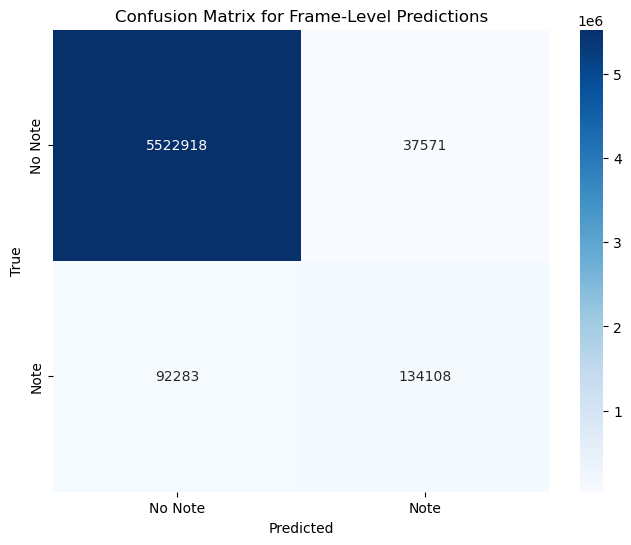

True Negatives (No Note, Predicted No Note): 5522918
False Positives (No Note, Predicted Note): 37571
False Negatives (Note, Predicted No Note): 92283
True Positives (Note, Predicted Note): 134108


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
ROOT_DIR = "/nfsshare/selva/maestro-v2.0.0"
OUTPUT_DIR = os.path.join(ROOT_DIR, "preprocessed")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    if not train_rolls:
        raise ValueError(f"No .npy files found in {train_roll_dir}")
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out, **kwargs):
        super(GCNSimple, self).__init__(**kwargs)
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)
    
    def get_config(self):
        config = super(GCNSimple, self).get_config()
        config.update({'dim_in': self.fc1.units, 'dim_out': self.fc3.units})
        return config

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.25),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features),
        layers.Dropout(0.5)
    ])
    return model

# OnsetsAndFrames model
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48, **kwargs):
        super(OnsetsAndFrames, self).__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.model_complexity = model_complexity
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {'onset': onset_pred, 'offset': offset_pred, 'frame': frame_pred}
    
    def get_config(self):
        config = super(OnsetsAndFrames, self).get_config()
        config.update({
            'input_features': self.input_features,
            'output_features': self.output_features,
            'model_complexity': self.model_complexity
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        input_features = config.get('input_features', N_MELS)
        output_features = config.get('output_features', NOTES)
        model_complexity = config.get('model_complexity', 48)
        return cls(input_features=input_features, 
                   output_features=output_features, 
                   model_complexity=model_complexity)

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=1, shuffle=False):
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        # Ensure 3D shape
        if X.ndim == 2:
            X = np.expand_dims(X, axis=0)
        if y.ndim == 2:
            y = np.expand_dims(y, axis=0)
        
        # Transpose to (batch, frames, features)
        if X.shape[1] == N_MELS and X.shape[2] == TARGET_FRAMES:
            X = np.transpose(X, (0, 2, 1))
        elif X.shape[1] != TARGET_FRAMES or X.shape[2] != N_MELS:
            raise ValueError(f"Unexpected X shape: {X.shape}")
        
        if y.shape[1] == NOTES and y.shape[2] == TARGET_FRAMES:
            y = np.transpose(y, (0, 2, 1))
        elif y.shape[1] != TARGET_FRAMES or y.shape[2] != NOTES:
            raise ValueError(f"Unexpected y shape: {y.shape}")
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.audio_files))
            np.random.shuffle(indices)
            self.audio_files = [self.audio_files[i] for i in indices]
            self.roll_files = [self.roll_files[i] for i in indices]

# Load model
try:
    model = tf.keras.models.load_model(
        "best_model.h5",
        custom_objects={'OnsetsAndFrames': OnsetsAndFrames, 'GCNSimple': GCNSimple}
    )
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# Validation generator
val_gen = PianoDataGenerator('validation', batch_size=1, shuffle=False)

# Collect predictions and ground truth
y_true = []
y_pred = []

for i in range(len(val_gen)):
    try:
        X, y = val_gen[i]
        preds = model.predict(X, verbose=0)
        pred_frame = preds['frame']
        pred_frame = (pred_frame >= 0.5).astype(int)  # Binarize
        y_true.append(y.flatten())  # y is array, not dict
        y_pred.append(pred_frame.flatten())
        print(f"Processed batch {i}")
    except Exception as e:
        print(f"Skipping batch {i}: {e}")
        continue

# Check if we have predictions
if not y_true or not y_pred:
    raise ValueError("No valid predictions generated. Check model and data.")

# Concatenate
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Note', 'Note'], 
            yticklabels=['No Note', 'Note'])
plt.title('Confusion Matrix for Frame-Level Predictions')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Print details
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (No Note, Predicted No Note): {tn}")
print(f"False Positives (No Note, Predicted Note): {fp}")
print(f"False Negatives (Note, Predicted No Note): {fn}")
print(f"True Positives (Note, Predicted Note): {tp}")

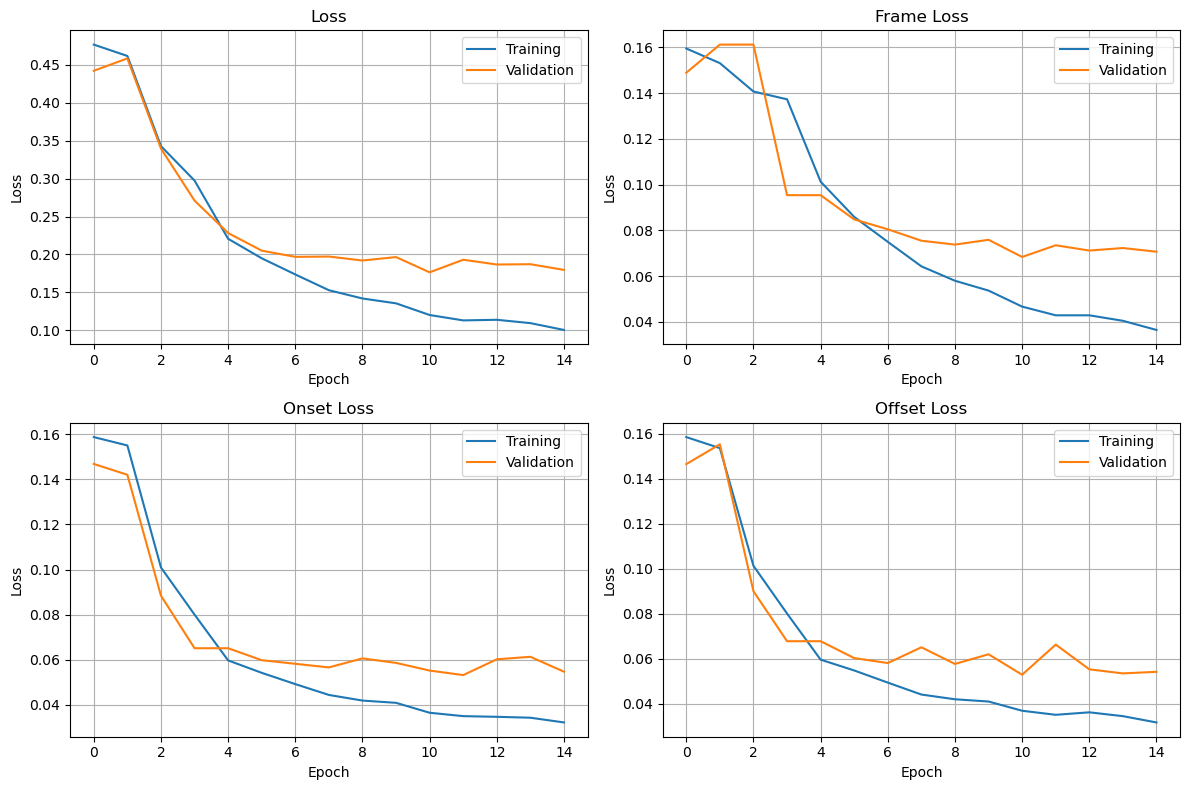

In [2]:
import matplotlib.pyplot as plt

# Reconstructed history from your logs (epochs 2–18, adjusted to start at epoch 1)
history = {
    'loss': [0.4767, 0.4617, 0.3428, 0.2974, 0.2206, 0.1949, 0.1736, 0.1528, 0.1419, 0.1355, 0.1201, 0.1130, 0.1138, 0.1094, 0.1004],
    'frame_loss': [0.1595, 0.1531, 0.1407, 0.1373, 0.1013, 0.0859, 0.0750, 0.0643, 0.0580, 0.0537, 0.0467, 0.0429, 0.0429, 0.0405, 0.0365],
    'onset_loss': [0.1587, 0.1550, 0.1009, 0.0800, 0.0597, 0.0542, 0.0492, 0.0444, 0.0419, 0.0409, 0.0365, 0.0350, 0.0347, 0.0343, 0.0322],
    'offset_loss': [0.1585, 0.1536, 0.1013, 0.0801, 0.0596, 0.0548, 0.0494, 0.0441, 0.0420, 0.0410, 0.0369, 0.0351, 0.0362, 0.0345, 0.0317],
    'val_loss': [0.4422, 0.4585, 0.3396, 0.27098, 0.2282, 0.2050, 0.1968, 0.1972, 0.1920, 0.1965, 0.1764, 0.1930, 0.1867, 0.1871, 0.1796],
    'val_frame_loss': [0.1489, 0.1612, 0.1612, 0.0954, 0.0954, 0.0848, 0.0805, 0.0755, 0.0738, 0.0759, 0.0684, 0.0735, 0.0712, 0.0723, 0.0707],
    'val_onset_loss': [0.1468, 0.1420, 0.0884, 0.0651, 0.0651, 0.0598, 0.0582, 0.0566, 0.0606, 0.0586, 0.0552, 0.0532, 0.0602, 0.0613, 0.0547],
    'val_offset_loss': [0.1465, 0.1553, 0.0900, 0.0678, 0.0678, 0.0603, 0.0581, 0.0651, 0.0577, 0.0620, 0.0529, 0.0663, 0.0553, 0.0535, 0.0542]
}

# Plotting function
def plot_loss_curves(history):
    metrics = ['loss', 'frame_loss', 'onset_loss', 'offset_loss']
    plt.figure(figsize=(12, 8))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history[metric], label='Training')
        plt.plot(history[f'val_{metric}'], label='Validation')
        plt.title(f'{metric.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('loss_curves.png')
    plt.show()

# Plot
plot_loss_curves(history)